<h1 style="font-size:30px;text-align: center;">- Advanced Machine Learning Methods  - Student Project -</h1>
<h1 style="font-size:25px;text-align: center;">- Seafood images classification -</h1>

<div style="width:100%;text-align: center;"> <img align=middle src="https://repozitorij.algebra.hr/sites/repozitorij.algebra.hr/files/algebra_subbrand_vu_color-black_h_1.png" alt="Algebra" style="margin-top:3rem;"> </div>


===================================================================================================================


<b>*Made: June 2021.* </b>

<b>*Author: Mislav Spajić*</b>


https://github.com/MySlav/seafood-classification-cnn


# Table of Contents

[1. Introduction](#introduction)
   > [1.1. Goal of the project](#goal)   
   > [1.2. Dataset description](#dataset)  
   

[2. Prerequisites](#prereq)


[3. Exploratory data analysis](#eda)
    

[4. Data preparation](#prep)

   
[5. Model definition](#mod_def)
  
[6. Model training](#mod_training)

   
[7. Model evaluation after training](#mod_eval) 

[8. Model qualitative analysis](#mod_qual) 


[8. Conclusion](#conclusion) 

# 1. Introduction<a name="introduction"></a>

### 1.1. Goal of the project<a name="goal"></a>

&nbsp;&nbsp;&nbsp;&nbsp;Goal of this student project is to successfully apply knowledge learnt in the class 'Advanced Machine Learning Methods' on a dataset of our choice. We need to utilize some deep learning methods to solve a particular problem. I have chosen to deal with image classification and will try to solve this problem utilizing a Convolutional Neural Network (CNN). I will utilize transfer learning method, I will load some of the pretrained models like 'DenseNet', 'MobileNetV2' and 'ResNet' and change the final layer. The parameters for the rest of the network will be frozen. If I notice that doesn't work good, I will try to fine-tune the preloaded layers aswell. I have chosen a dataset which contains images of 9 different seafood types. More details about the dataset in the next chapter.

### 1.2. Dataset description<a name="dataset"></a>

&nbsp;&nbsp;&nbsp;&nbsp;This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey for a university-industry collaboration project at Izmir University of Economics, and this work was published in ASYU 2020.


&nbsp;&nbsp;&nbsp;&nbsp;The dataset includes gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples.

&nbsp;&nbsp;&nbsp;&nbsp;Images were collected via 2 different cameras, Kodak Easyshare Z650 and Samsung ST60.

&nbsp;&nbsp;&nbsp;&nbsp;Therefore, the resolution of the images are 2832 x 2128, 1024 x 768, respectively.


&nbsp;&nbsp;&nbsp;&nbsp;Although authors provide a set in which they have done resizing of pictures to a fixed size and they have generated more pictures using data augmentation techniques, I will use the original set and try to do these things myself.

# 2. Prerequisites<a name="prereq"></a>

&nbsp;&nbsp;&nbsp;&nbsp;Importing needed Python libraries & modules and initial setup.

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import PIL
import torch
import torchvision
import albumentations
import gc
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import OrderedDict
from torchvision import transforms, models,utils
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

In [143]:
# Defining directory with data
Dir = '/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset'
os.listdir(Dir)

['Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Red Sea Bream',
 'Horse Mackerel',
 'Gilt Head Bream']

In [144]:
# Creating a dataframe of paths and labels
data = {"path": [],
        "label": []
        }

for i in os.listdir(Dir):
  path = os.path.join(Dir, i)
  for j in os.listdir(path):
    data['path'].append(os.path.join(path, j))
    data['label'].append(i)

data_df=pd.DataFrame.from_dict(data)

In [145]:
# Checking how does the created dataframe look
data_df

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Black Sea Sprat
1,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Black Sea Sprat
2,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Black Sea Sprat
3,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Black Sea Sprat
4,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Black Sea Sprat
...,...,...
425,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Gilt Head Bream
426,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Gilt Head Bream
427,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Gilt Head Bream
428,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,Gilt Head Bream


# 3. Exploratory data analysis<a name="eda"></a>

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    430 non-null    object
 1   label   430 non-null    object
dtypes: object(2)
memory usage: 6.8+ KB


In [6]:
data_df["label"].value_counts()

Shrimp                50
Red Mullet            50
Red Sea Bream         50
Horse Mackerel        50
Sea Bass              50
Black Sea Sprat       50
Striped Red Mullet    50
Gilt Head Bream       50
Trout                 30
Name: label, dtype: int64

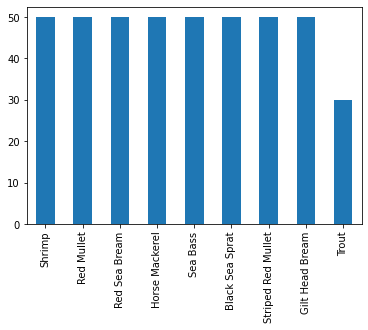

In [7]:
data_df["label"].value_counts().plot.bar()
plt.show()

We can see that dataset is very balanced, all the classes except "Trout" have equal number of pictures (50). I won't have a problem with class imbalance and accuracy can be used as a measure of performance.

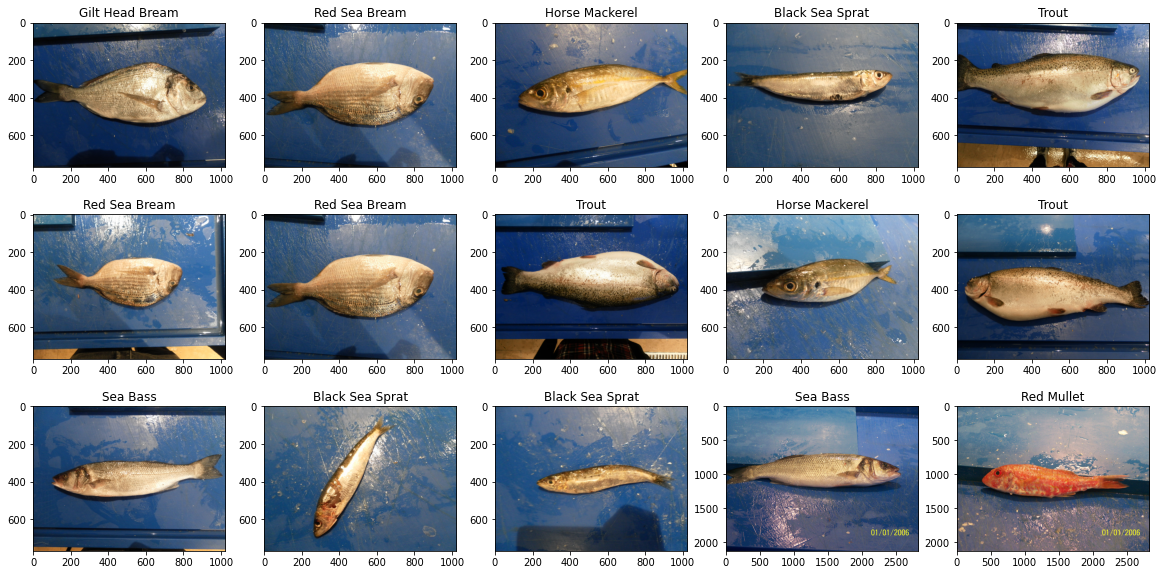

In [8]:
# Showing 15 random images
plt.figure(figsize=(20,10))

for i in range(15):
    row=data_df.sample().reset_index(drop=True)
    img = np.asarray(PIL.Image.open(row["path"][0]))
    plt.subplot(3, 5, i+1)
    plt.gca().set_title(row["label"][0])
    plt.imshow(img)
plt.show()

In [9]:
# Finding all the unique formats and dimensions of images in the dataset
dimensions=[]
formats=[]

for row in data_df.iterrows():
    img = PIL.Image.open(row[1]["path"])

    dimensions.append(np.asarray(img).shape)
    formats.append(img.format)
    
print("Dimensions of the pictures in the dataset are:", set(dimensions))
print("Formats of the pictures in the dataset are:", set(formats))

Dimensions of the pictures in the dataset are: {(2128, 2832, 3), (768, 1024, 3)}
Formats of the pictures in the dataset are: {'JPEG', 'PNG', 'MPO'}


We can see that all pictures have 3 channels but they have different dimensions, we will deal with that later on when we initialize dataloaders.

In [10]:
# How many of images with particular dimension are there
[[x,dimensions.count(x)] for x in set(dimensions)]

[[(2128, 2832, 3), 158], [(768, 1024, 3), 272]]

In [11]:
# How many of images with particular format are there
[[x,formats.count(x)] for x in set(formats)]

[['JPEG', 159], ['PNG', 1], ['MPO', 270]]

In [12]:
# Installing nice library for image EDA
!pip install basic-image-eda


found 430 images.


  0%|          | 0/430 [00:00<?, ?it/s]

Using 2 threads. (max:2)



100%|██████████| 430/430 [01:25<00:00,  5.02it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  430

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpeg', 'png', 'JPG']

min height                               |  768
max height                               |  2128
mean height                              |  1267.7209302325582
median height                            |  768

min width                                |  1024
max width                                |  2832
mean width                               |  1688.3348837209303
median width                             |  1024

mean height/width ratio                  |  0.7508705426014899
median height/width ratio                |  0.75
recommended input size(by mean)          |  [1264 1688] (h x w, multiples of 8)
recommended input size(by mean)          |  [1264 1696] (h x w, multiples of 16)
re

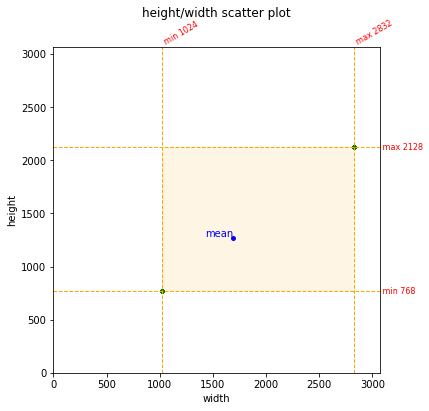

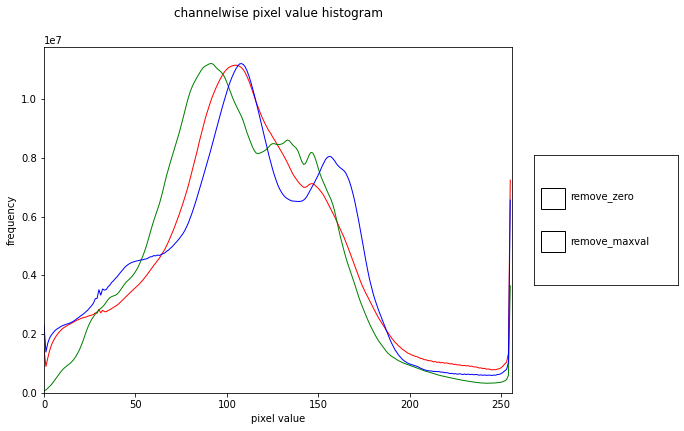

{'dtype': 'uint8',
 'channels': [3],
 'extensions': ['jpeg', 'png', 'JPG'],
 'min_h': 768,
 'max_h': 2128,
 'mean_h': 1267.7209302325582,
 'median_h': 768,
 'min_w': 1024,
 'max_w': 2832,
 'mean_w': 1688.3348837209303,
 'median_w': 1024,
 'mean_hw_ratio': 0.7508705426014899,
 'median_hw_ratio': 0.75,
 'rec_hw_size_8': array([1264, 1688]),
 'rec_hw_size_16': array([1264, 1696]),
 'rec_hw_size_32': array([1280, 1696]),
 'mean': array([0.4109598 , 0.40690383, 0.4242128 ], dtype=float32),
 'std': array([0.21329764, 0.18420503, 0.20046176], dtype=float32)}

In [13]:
# Usage - https://pypi.org/project/basic-image-eda/
from basic_image_eda import BasicImageEDA

data_dir = Dir
extensions = ['png','PNG' 'jpg', 'jpeg', 'JPG','JPEG']
threads = 0
dimension_plot = True
channel_hist = True
nonzero = False
hw_division_factor = 1.0

BasicImageEDA.explore(data_dir,extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

# 4. Data preparation<a name="prep"></a>

In [146]:
# Encoding labels to integers
le = LabelEncoder()
data_df['label'] = le.fit_transform(data_df['label'])

In [147]:
# We can pull class names with this
le.classes_

array(['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel',
       'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp',
       'Striped Red Mullet', 'Trout'], dtype=object)

In [148]:
# Dataframe looks like this now
data_df.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0
1,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0
2,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0
3,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0
4,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0


In [149]:
# Adding dimensions to df
data_df["camera"]=dimensions

# Converting tuples to str to encode them
data_df["camera"]=data_df["camera"].apply(lambda x: str(x))

In [150]:
#Encoding
le2 = LabelEncoder()
data_df['camera'] = le2.fit_transform(data_df['camera'])

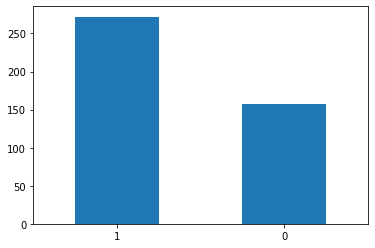

In [151]:
#Distribution by cameras
data_df["camera"].value_counts().plot.bar(rot=0)
plt.show()

In [152]:
data_df

,path,label,camera
0,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0,1
1,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0,1
2,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0,1
3,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0,1
4,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,0,1
...,...,...,...
425,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,1,0
426,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,1,0
427,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,1,1
428,/kaggle/input/a-large-scale-fish-dataset/NA_Fi...,1,0


In [153]:
data_df["label_camera"]=data_df["label"].astype(str)+'_'+data_df["camera"].astype(str)

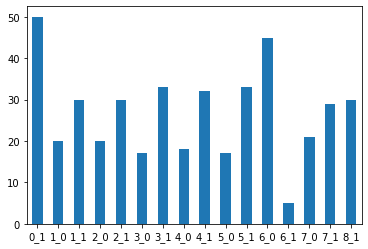

In [154]:
# Distribution of combinations of camera and class
data_df["label_camera"].value_counts().sort_index().plot.bar(rot=0)
plt.show()

In [104]:
# Splitting train - test, 70-30 %, using stratified split by label_camera combination
train,  test = train_test_split(data_df, test_size = 0.3, random_state = 42, stratify=data_df["label_camera"])

# Had trouble implementing k-fold CV with pytorch, so I decided to go with regular train-valid-test split
train,  valid = train_test_split(train, test_size = 0.4, random_state = 42, stratify=train["label_camera"])

print(f"train set shape: {train.shape}")
print(f"test set shape: {test.shape}")
print(f"valid set shape: {valid.shape}")

# Final ratios of sets are train (42 %) - valid (28 %) - test (30 %)
# Decided to go this route since I deal with low number of rows, and I will augment the test data several times

train set shape: (180, 4)
test set shape: (129, 4)
valid set shape: (121, 4)


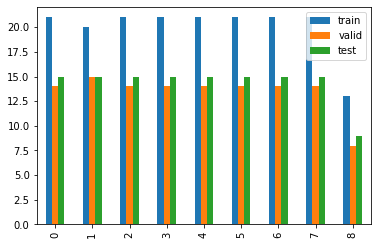

In [105]:
# Checking distribution of seafood classes after split
_, train_counts = np.unique(train["label"], return_counts=True)
_, test_counts = np.unique(test["label"], return_counts=True)
_, valid_counts = np.unique(valid["label"], return_counts=True)
pd.DataFrame({'train': train_counts,
              'valid' : valid_counts,
                    'test': test_counts},
             index=le.classes_
             
            ).plot.bar()
plt.show()

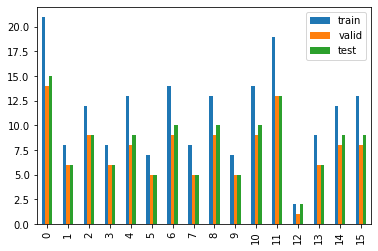

In [106]:
# Checking distribution of seafood classes by label and camera type after split
_, train_counts = np.unique(train["label_camera"], return_counts=True)
_, test_counts = np.unique(test["label_camera"], return_counts=True)
_, valid_counts = np.unique(valid["label_camera"], return_counts=True)
pd.DataFrame({'train': train_counts,
              'valid' : valid_counts,
                    'test': test_counts} 
             
            ).plot.bar()
plt.show()

In [107]:
# Loading all train images to arrays to perform data augmentations before training
train_x = []
for path in tqdm(train['path']):
    img = np.asarray(PIL.Image.open(path))
    train_x.append(img)

train_y = train['label'].values
len(train_x), train_y.shape

100%|██████████| 180/180 [00:08<00:00, 22.02it/s]


(180, (180,))

In [108]:
# Defining augmentations
"""All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."""

albumentations_transform = albumentations.Compose([
    albumentations.SmallestMaxSize(224), 
    albumentations.CenterCrop(224, 224),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

albumentations_transform2 = albumentations.Compose([
    albumentations.SmallestMaxSize(224), 
    albumentations.CenterCrop(224, 224),
    albumentations.Rotate(p=0.3),
    albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
    albumentations.OneOf([
                          albumentations.RandomRotate90(p=1),
                          albumentations.HorizontalFlip(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [109]:
# Data will be augmented before training and stored in RAM, later on I will push it to GPU memory during training
# This way I will get more reproducible results
augmented_train_data = []
augmented_target_train = []
num_aug=6 # Number of augmented images to be generated for each original - This results in 140 images in each class
for i in tqdm(range(len(train_x))):
    augmented_train_data.append(albumentations_transform(image=train_x[i])) # Original image just resized and cropped
    for j in range(num_aug):
        augmented_train_data.append(albumentations_transform2(image=train_x[i]))
    for k in range(num_aug+1):
        augmented_target_train.append(train_y[i])

100%|██████████| 180/180 [00:05<00:00, 30.67it/s]


In [110]:
len(augmented_train_data), len(augmented_target_train)

(1260, 1260)

In [111]:
# Saving the augmented set to dataframe and deleting previous objects
augmented_train = pd.DataFrame.from_dict(augmented_train_data)
augmented_train["label"] = augmented_target_train

del train_x, train_y, augmented_train_data, augmented_target_train
gc.collect()

59528

In [112]:
# Split ratios now in practice
print("Training: {:.2f}".format(len(augmented_train)/(len(augmented_train)+len(test)+len(valid))))
print("Validation: {:.2f}".format(len(valid)/(len(augmented_train)+len(test)+len(valid))))
print("Test: {:.2f}".format(len(test)/(len(augmented_train)+len(test)+len(valid))))

Training: 0.83
Validation: 0.08
Test: 0.09


In [113]:
augmented_train["image"][0].shape

(224, 224, 3)

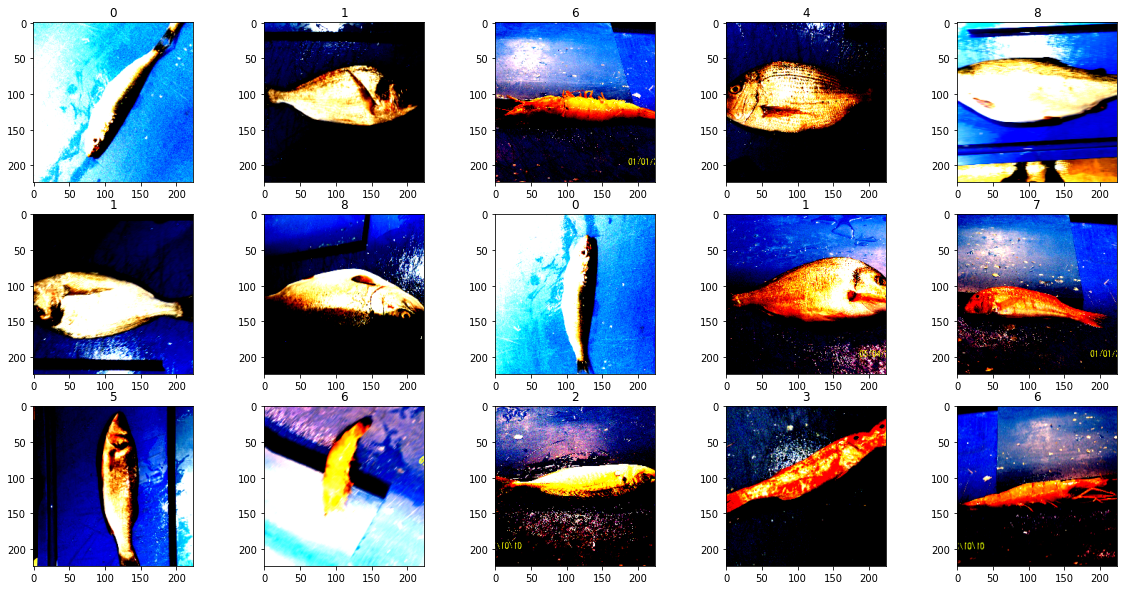

In [34]:
# Showing 15 random images from train after augmentations
plt.figure(figsize=(20,10))

for i in range(15):
    row=augmented_train.sample().reset_index(drop=True)
    img = np.asarray(row["image"][0])
    plt.subplot(3, 5, i+1)
    plt.gca().set_title(row["label"][0])
    plt.imshow(img)
plt.show()

In [115]:
# Defining dataset classes
class MyTrainDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        image=torchvision.transforms.functional.to_tensor(row["image"])
            
        return (
            image,
            row["label"]
        )


class MyTestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        image=np.asarray(PIL.Image.open(row["path"]))
        
        if self.transform:
            image = self.transform(image=image)["image"]
            image = torchvision.transforms.functional.to_tensor(image)
        return (
            image,
            row["label"]
        )
    

# Initializing datasets
dataset_train = MyTrainDataset(augmented_train)
dataset_valid = MyTestDataset(valid,transform=albumentations_transform)
dataset_test = MyTestDataset(test,transform=albumentations_transform)

In [116]:
# Initializing dataloaders
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=16)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=16)

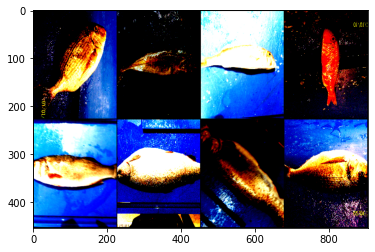

In [166]:
# To see does the data look ok in dataloader class, code taken from homework
dataiter = iter(trainloader)
images = dataiter.next()
plt.imshow(utils.make_grid(images[0][0:8],nrow=4).permute(1,2,0),aspect='auto')
plt.show()

# 5. Model definition<a name="mod_def"></a>

In [118]:
# To check if GPU is properly allocated
!nvidia-smi

Sun Jun 27 16:42:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   1597MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [119]:
# Defining device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [120]:
# https://pytorch.org/vision/stable/models.html
densenet=models.densenet161(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)
resnet = models.resnet152(pretrained=True)
all_models = [densenet,mobilenet,resnet]

In [121]:
# Modifying last layers, adding the same Sequential container as last element to all 3

for model in all_models:
    classifier_name, old_classifier = model._modules.popitem() 
    # Needed because resnet  has no "classifier" as name of the last layer but "fc" and to store input size

    # Freeze parameters so we don't backprop through them - code taken from HW
    for param in model.parameters():
        param.requires_grad = False
    
    # Some of the models have a seqential container as last element   
    if type(old_classifier) == torch.nn.modules.container.Sequential:
        classifier_input_size = old_classifier[len(old_classifier)-1].in_features   
    else:
        classifier_input_size = old_classifier.in_features
    classifier = torch.nn.Sequential(OrderedDict([
                              ('fc1', torch.nn.Linear(classifier_input_size, 512)),
                              ('relu', torch.nn.ReLU()),
                              ('dropout', torch.nn.Dropout(p=0.5)),
                              ('fc2', torch.nn.Linear(512, 9)),
                              ('output', torch.nn.LogSoftmax(dim=1))
                              ]))
    model.add_module(classifier_name, classifier)


    model.to(device)

In [122]:
# Using the same loss criterion and optimizer for all of the models, also the same learning rate and number of epochs will be used

criterion = torch.nn.NLLLoss()
optimizer_densenet = torch.optim.Adagrad(densenet.classifier.parameters(), lr=0.01)
optimizer_mobilenet = torch.optim.Adagrad(mobilenet.classifier.parameters(), lr=0.01)
optimizer_resnet = torch.optim.Adagrad(resnet.fc.parameters(), lr=0.01)

# 6. Model training<a name="mod_training"></a>

In [123]:
# Modified code from homework - helper function for training

def training(model, optimizer, criterion, trainloader, testloader):
    epochs = 5
    steps = 0
    running_loss = 0

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        

 

        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                    
                test_loss += batch_loss.item()
                    
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        running_loss = 0
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(test_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(testloader)))
        
    return train_losses,test_losses

In [124]:
# ResNet 152 Training
train_losses,valid_losses = training(resnet, optimizer_resnet, criterion, trainloader, validloader)

Epoch: 1/5..  Training Loss: 2.840..  Validation Loss: 0.720..  Validation Accuracy: 0.938
Epoch: 2/5..  Training Loss: 0.910..  Validation Loss: 0.420..  Validation Accuracy: 0.938
Epoch: 3/5..  Training Loss: 0.690..  Validation Loss: 0.308..  Validation Accuracy: 0.953
Epoch: 4/5..  Training Loss: 0.573..  Validation Loss: 0.236..  Validation Accuracy: 0.992
Epoch: 5/5..  Training Loss: 0.504..  Validation Loss: 0.208..  Validation Accuracy: 0.977


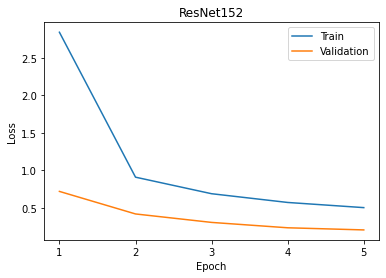

In [125]:
plt.figure()
plt.title("ResNet152")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xticks(np.arange(len(train_losses)), np.arange(1, len(train_losses)+1))
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()

In [126]:
# MobileNet_V2
train_losses,valid_losses = training(mobilenet, optimizer_mobilenet, criterion, trainloader, validloader)

Epoch: 1/5..  Training Loss: 1.919..  Validation Loss: 0.520..  Validation Accuracy: 0.898
Epoch: 2/5..  Training Loss: 0.674..  Validation Loss: 0.256..  Validation Accuracy: 0.984
Epoch: 3/5..  Training Loss: 0.493..  Validation Loss: 0.179..  Validation Accuracy: 0.977
Epoch: 4/5..  Training Loss: 0.382..  Validation Loss: 0.178..  Validation Accuracy: 0.945
Epoch: 5/5..  Training Loss: 0.327..  Validation Loss: 0.115..  Validation Accuracy: 0.984


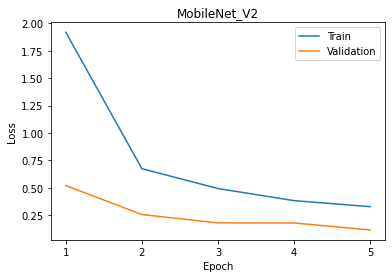

In [127]:
plt.figure()
plt.title("MobileNet_V2")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xticks(np.arange(len(train_losses)), np.arange(1, len(train_losses)+1))
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()

In [128]:
# DenseNet161
train_losses,valid_losses = training(densenet, optimizer_densenet, criterion, trainloader, validloader)

Epoch: 1/5..  Training Loss: 1.901..  Validation Loss: 0.639..  Validation Accuracy: 0.836
Epoch: 2/5..  Training Loss: 0.663..  Validation Loss: 0.300..  Validation Accuracy: 0.961
Epoch: 3/5..  Training Loss: 0.449..  Validation Loss: 0.245..  Validation Accuracy: 0.945
Epoch: 4/5..  Training Loss: 0.311..  Validation Loss: 0.145..  Validation Accuracy: 0.984
Epoch: 5/5..  Training Loss: 0.269..  Validation Loss: 0.121..  Validation Accuracy: 0.984


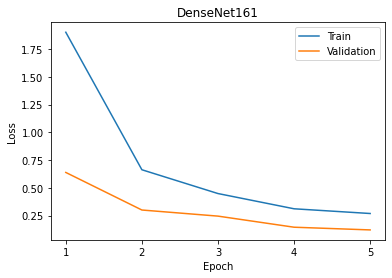

In [129]:
plt.figure()
plt.title("DenseNet161")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xticks(np.arange(len(train_losses)), np.arange(1, len(train_losses)+1))
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()

# 7. Model evaluation after training<a name="mod_eval"></a>

&nbsp;&nbsp;&nbsp;&nbsp;Since MobileNet_V2 based model has shown to be the best on validation set, predictions and evaluation on the test set will be done with it.


In [134]:
# Predictions - on mobilenet
# https://www.kaggle.com/abubakaryagob/fish-classification-with-pytorch-resnet - Modified code from this notebook
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_test_pred = mobilenet(inputs)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])

In [135]:
# Evaluation of predictions on test set

print(f"number of testing samples results: {len(flat_pred)}")
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

number of testing samples results: 129
Testing accuracy is: 93.02%


In [156]:
# Classification report
print(classification_report(flat_true, flat_pred, target_names=le.classes_))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.93      0.97        15
   Gilt Head Bream       1.00      0.87      0.93        15
    Horse Mackerel       0.83      1.00      0.91        15
        Red Mullet       0.93      0.93      0.93        15
     Red Sea Bream       0.93      0.93      0.93        15
          Sea Bass       0.87      0.87      0.87        15
            Shrimp       1.00      0.93      0.97        15
Striped Red Mullet       0.93      0.93      0.93        15
             Trout       0.90      1.00      0.95         9

          accuracy                           0.93       129
         macro avg       0.93      0.93      0.93       129
      weighted avg       0.93      0.93      0.93       129



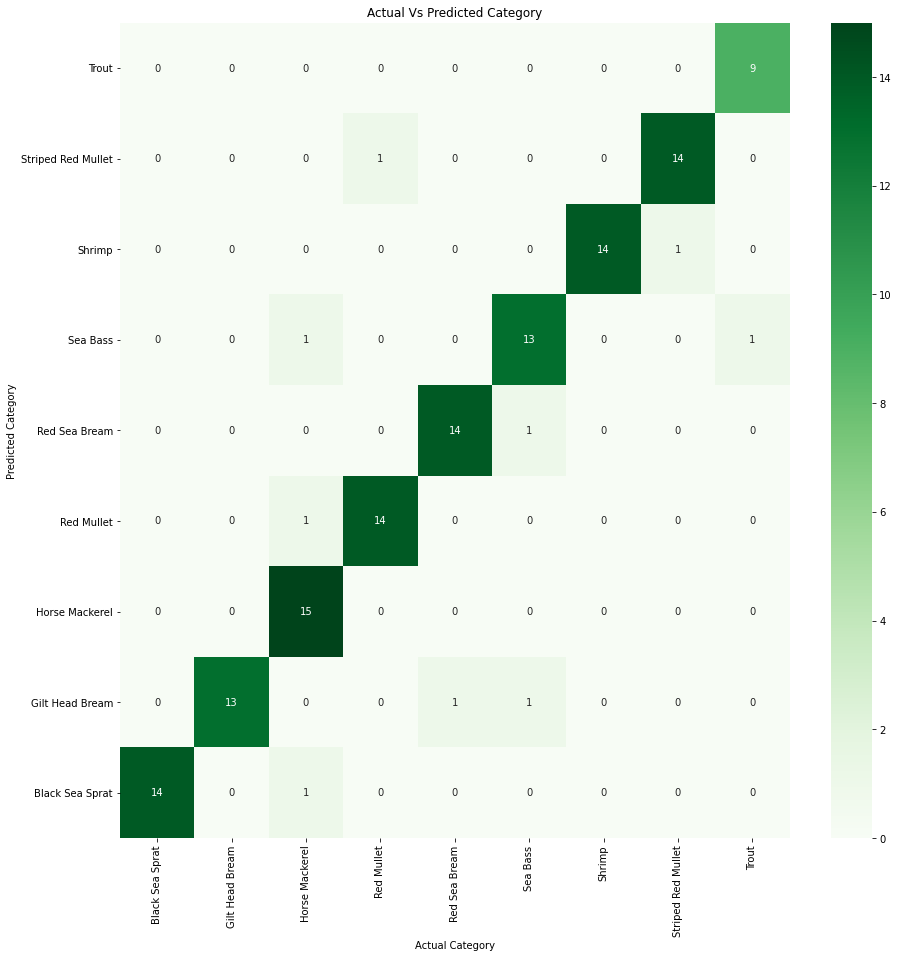

In [165]:
# Confusion Matrix
fig = plt.figure(figsize=(15,15))
conf = confusion_matrix(flat_true,flat_pred)
ax=sns.heatmap(conf,annot=True,cmap='Greens')
ax.invert_yaxis()
ax.set_xticklabels(le.classes_,rotation=90)
ax.set_yticklabels(le.classes_,rotation=0)
ax.set_xlabel('Actual Category')
ax.set_ylabel('Predicted Category')
ax.set_title('Actual Vs Predicted Category')
plt.show()

# 8. Model qualitative analysis<a name="mod_qual"></a>

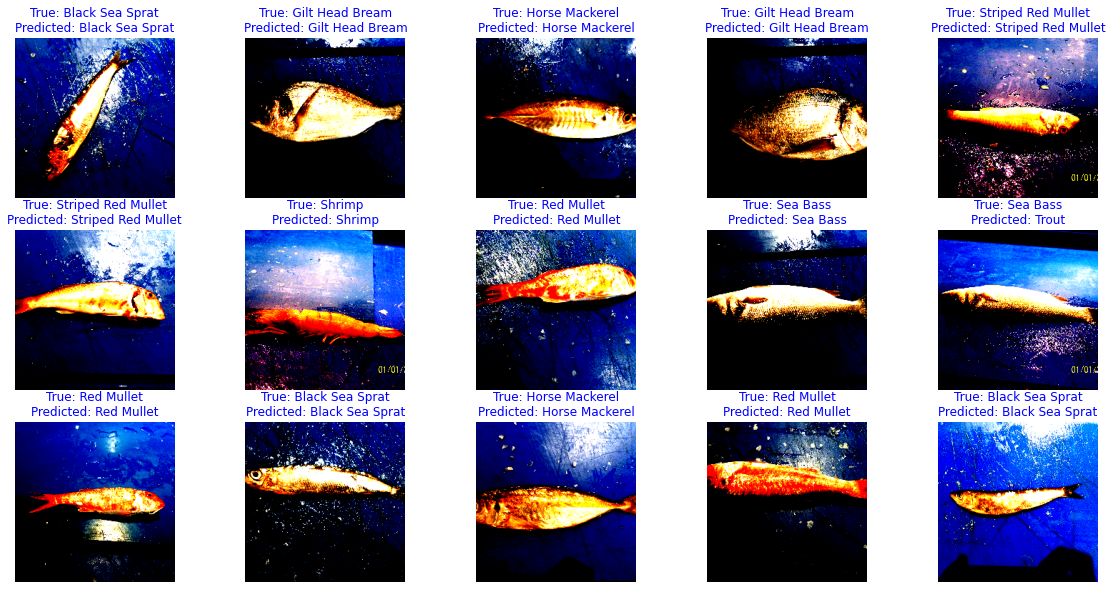

In [228]:
# Displays 15 random picture of the train dataset with their respective real and predicted labels

inds = np.random.randint(len(dataset_test), size=15)
j=1
plt.figure(figsize=(20,10))
for i in inds:
    img, label = dataset_test[i]
    plt.subplot(3, 5, j)
    plt.gca().set_title(f"True: {le.inverse_transform([label])[0]}\nPredicted: {le.inverse_transform([flat_pred[i]])[0]}",color='blue')
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    j+=1
    
plt.show()

# 9. Conclusion<a name="conclusion"></a>

&nbsp;&nbsp;&nbsp;&nbsp; By utilizing transfer learning I have easily gotten a Convolutional Neural Network with high accuracy for my seafood classification problem. 

&nbsp;&nbsp;&nbsp;&nbsp; I have downloaded 3 pretrained models from pytorch repository and changed only the last layer. Layer of same structure has been added to all 3. Weights of rest of the layers of the models were frozen.

&nbsp;&nbsp;&nbsp;&nbsp; MobileNet_V2 based model has shown to be the best on validation set and after testing it on test set, it has shown accuracy of 93 %, which is a great result given the size of the dataset and small number of optimizations I have done to the pretrained models.
